## Importing general libraries

In [27]:
# other libraries will be imported later, upon demand
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

## Description of dataset columns and preferred formats
[Reference link](https://www.kaggle.com/xwolf12/malicious-and-benign-websites/discussion/54433)

***URL***: it is the anonimous identification of the URL analyzed in the study

***URL_LENGTH***: it is the number of characters in the URL

***NUMBER_SPECIAL_CHARACTERS***: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”

***CHARSET***: it is a categorical value and its meaning is the character encoding standard (also called character set).

***SERVER***: it is a categorical value and its meaning is the operative system of the server got from the packet response.

***CONTENT_LENGTH***: it represents the content size of the HTTP header.

***WHOIS_COUNTRY***: it is a categorical variable, its values are the countries we got from the server response (specifically, our script used the API of Whois).

***WHOIS_STATEPRO***: it is a categorical variable, its values are the states we got from the server response (specifically, our script used the API of Whois).

***WHOIS_REGDATE***: Whois provides the server registration date, so, this variable has date values with format DD/MM/YYY HH:MM

***WHOIS_UPDATED_DATE***: Through the Whois we got the last update date from the server analyzed

***TCP_CONVERSATION_EXCHANGE***: This variable is the number of TCP packets exchanged between the server and our honeypot client

***DIST_REMOTE_TCP_PORT***: it is the number of the ports detected and different to TCP

***REMOTE_IPS***: this variable has the total number of IPs connected to the honeypot

***APP_BYTES***: this is the number of bytes transfered

***SOURCE_APP_PACKETS***: packets sent from the honeypot to the server

***REMOTE_APP_PACKETS***: packets received from the server

***APP_PACKETS***: this is the total number of IP packets generated during the communication between the honeypot and the server

***DNS_QUERY_TIMES***: this is the number of DNS packets generated during the communication between the honeypot and the server

***TYPE***: this is a categorical variable, its values represent the type of web page analyzed, specifically, 1 is for malicious websites and 0 is for benign websites


### Column formats

Considering the above description, it is proposed to initially give folloiwng formats to columns:

**string**:
- *URL*, *CHARSET*, *SERVER*, *CONTENT_LENGTH*, *WHOIS_COUNTRY*, *WHOIS_STATEPRO* 

**string or date**:
- *WHOIS_REGDATE*, *WHOIS_UPDATED_DATE*

**numeric - int or float**:
- *URL_LENGTH*, *NUMBER_SPECIAL_CHARACTERS*, *CONTENT_LENGTH*, *TCP_CONVERSATION_EXCHANGE*, *DIST_REMOTE_TCP_PORT*, *REMOTE_IPS*, *APP_BYTES*, *SOURCE_APP_PACKETS*, *REMOTE_APP_PACKETS*, *SOURCE_APP_BYTES*, *REMOTE_APP_BYTES*, *APP_PACKETS*, *DNS_QUERY_TIMES*, *Type*

The chosen formats for columns may change after the **Feature engineering** and **Feature selection** phases.

## Loading data

In [86]:
dtype_string_columns = {'URL': str,
                        'CHARSET': str,
                        'SERVER': str,
                        'WHOIS_COUNTRY': str,
                        'WHOIS_STATEPRO': str,
                        'WHOIS_REGDATE': str,
                        'WHOIS_UPDATED_DATE': str}

dtype_int_columns = {'NUMBER_SPECIAL_CHARACTERS': int,
                     'CONTENT_LENGTH': int,
                     'TCP_CONVERSATION_EXCHANGE': int,
                     'DIST_REMOTE_TCP_PORT': int,
                     'REMOTE_IPS': int,
                     'APP_BYTES': int,
                     'SOURCE_APP_PACKETS': int,
                     'REMOTE_APP_PACKETS': int,
                     'SOURCE_APP_BYTES': int,
                     'REMOTE_APP_BYTES': int,
                     'APP_PACKETS': int,
                     'DNS_QUERY_TIMES': int,
                     'Type': int}

dtype = {'URL': str,
         'URL_LENGTH': int,
         'NUMBER_SPECIAL_CHARACTERS': int,
         'CHARSET': str,
         'SERVER': str,
         'CONTENT_LENGTH': int,
         'WHOIS_COUNTRY': str,
         'WHOIS_STATEPRO': str,
         'WHOIS_REGDATE': str,
         'WHOIS_UPDATED_DATE': str,
         'TCP_CONVERSATION_EXCHANGE': int,
         'DIST_REMOTE_TCP_PORT': int,
         'REMOTE_IPS': int,
         'APP_BYTES': int,
         'SOURCE_APP_PACKETS': int,
         'REMOTE_APP_PACKETS': int,
         'SOURCE_APP_BYTES': int,
         'REMOTE_APP_BYTES': int,
         'APP_PACKETS': int,
         'DNS_QUERY_TIMES': int,
         'Type': int}


When reading a CSV table into Pandas with `read_csv()`, columns get formats that are derived by the function.
One can assign columns' formats using the `dtype` parameter. It is also possible to assign formats to a subset of columns.


If a column contains missing values, it cannot be assigned to `int`. It must be either `string` (i.e. `object` in Pandas terms) or `float`.
Therefore, we assign `string` format to several columns that we are sure about, including those that contain dates. 
For the rest of columns we let Pandas derive numeric formats. Numeric columns must have the period as the decimal value delimiter, ex. `3.1415`.

In [159]:
df_train = pd.read_csv("data/Train.csv",
                       header=0,
                       sep=",",
                       dtype=dtype_string_columns
                       )

No errors were raised during data loading.

## Preliminary analysis of the dataset

Our training dataset contains 1431 rows and 21 columns; 20 predictor columns and 1 target.

In [88]:
# shape
df_train.shape

(1431, 21)

It looks like *URL* column serves as an index for observations and should not be used in training a model. Therefore, we can assume that there are 19 predictors. The numeric columns *CONTENT_LENGTH* and *DNS_QUERY_TIMES*, and string-based column *SERVER* contain missing values. **Data imputation** or **dropping the whole column** should be considered for these columns.

In [173]:
# missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        1431 non-null   object        
 1   URL_LENGTH                 1431 non-null   int64         
 2   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 3   CHARSET                    1431 non-null   object        
 4   SERVER                     1430 non-null   object        
 5   CONTENT_LENGTH             786 non-null    float64       
 6   WHOIS_COUNTRY              1431 non-null   object        
 7   WHOIS_STATEPRO             1431 non-null   object        
 8   WHOIS_REGDATE              1431 non-null   object        
 9   WHOIS_UPDATED_DATE         1431 non-null   object        
 10  TCP_CONVERSATION_EXCHANGE  1431 non-null   int64         
 11  DIST_REMOTE_TCP_PORT       1431 non-null   int64         
 12  REMOTE

Having a look at the number of unique values in columns can also be interesting. It may help to decide which columns to remove from consideration, for example constant columns. 

Looking at the number of unique values in combination with the `target` column, can help to understand if columns have valuable information for distinguishing between `positives` and `negatives`. Here we can see that the column *CHARSET* has 9 unique values in total. Almost all unique values are present in both target classes.

In [172]:
# unique values
d_unique_vals = {}
for col in df_train.columns.tolist():
    d_unique_vals[col] = df_train[col].nunique()
    
(df_train.groupby('Type').nunique().T.
 merge(pd.Series(d_unique_vals, name='unique_vals'),
       right_index=True, left_index=True)
 )

,0,1,unique_vals
URL,1272,159,1431
URL_LENGTH,124,68,135
NUMBER_SPECIAL_CHARACTERS,26,24,29
CHARSET,8,7,9
SERVER,231,27,239
CONTENT_LENGTH,500,48,540
WHOIS_COUNTRY,42,21,49
WHOIS_STATEPRO,164,36,182
WHOIS_REGDATE,720,54,769
WHOIS_UPDATED_DATE,519,49,542


We can see that the dataset is imbalanced. Only about `11%` of observations belong to the `positive` class. One should take this into account when splitting data into train, validation and test subsets as well as during cross-validation. It is also possible to try some re-sampling methods to balance the classes (upsampling or undersampling). 

In [92]:
df_train.Type.value_counts(normalize=True).round(2)

0    0.89
1    0.11
Name: Type, dtype: float64

## Pair plot
It is possible to create a scatter plot for every pair of numeric features. The `pairplot()` function of the `Seaborn` library gives such a graph. Using different colors for dots of different target classes, one can 
visualize if the two classes are separable. 

Since the input table is not large, we can use the `pairplot()` function on the whole dataset. However, generating this plot is a demanding task and may take a long time.

In [19]:
# sns.pairplot(df_train, hue='Type')

# Data analysis and Feature engineering

## Formatting datetime columns
Original datetime columns have different string formats. Also they contain non-datetime values that need to be processed. We use string-length of datetime values to differentiate between formats and to find non-datetime values.

In [168]:
df_train[['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']].head()

,WHOIS_REGDATE,WHOIS_UPDATED_DATE
0,None,None
1,None,None
2,7/10/1997 4:00,12/09/2013 0:45
3,12/05/1996 0:00,11/04/2017 0:00
4,3/08/2016 14:30,3/10/2016 3:45


In [176]:
df_train['WHOIS_REGDATE'].apply(lambda x: len(x)).value_counts()

15    939
14    365
4      89
16     30
22      5
1       3
Name: WHOIS_REGDATE, dtype: int64

In [162]:
df_train['WHOIS_UPDATED_DATE'].apply(lambda x: len(x)).value_counts()

15    843
14    384
16    103
4      96
22      5
Name: WHOIS_UPDATED_DATE, dtype: int64

In [101]:
non_date_values = set([s for s in df_train.WHOIS_REGDATE.values if len(s)<6])
non_date_values = non_date_values.union(set([s for s in df_train.WHOIS_UPDATED_DATE.values if len(s)<6]))
print(non_date_values)

{'b', '0', 'None'}


There are basically two date formats in the columns: `'%Y-%m-%dT%H:%M:%S.0Z'` and `'%d/%m/%Y %H:%M'`. The last one should always have length 16 to be properly read by the `pd.to_datetime()` function, but there are values with length 14 and 15. Values that have length 1 or 4 are missing values. We need to transform the date values to have correct string format.

In [174]:
def transform_dates(df, col):
    """
    Transforms date values from different string formats to '%d/%m/%Y %H:%M'.
    Uses string length of a given value as the basic parameter.
    Input: dataframe and name of the column to be transformed.
    Returns: list of date values in '%d/%m/%Y %H:%M' format.
    
    Examples of possible input values '12/05/1996 0:00', '3/08/2016 14:30',
    '7/10/1997 4:00', '2017-03-07T22:02:38.0Z'. Other inputs will be defauled to
    '31/12/1960 23:59'.
    """
    new_date_vals = []
    for date in df[col]:
        if len(date) == 14: # ex. '7/10/1997 4:00'
            day_ = '0'+ date.split(' ')[0]
            time_ = '0'+ date.split(' ')[1]
            date_ = day_ +' '+time_
        elif len(date)==15: # ex. '12/05/1996 0:00', '3/08/2016 14:30'
            day_ = date.split(' ')[0]
            time_ = date.split(' ')[1]
            if len(time_) == 4: # ex. 0:00
                time_ = '0'+ time_
            else:
                day_ = '0'+ day_
            date_ = day_ +' '+time_
        elif len(date)== 22: # ex. '2017-03-07T22:02:38.0Z'
            date_ = date[8:10]+'/'+date[5:7]+'/'+date[:4]+' '+date[11:16]
        elif len(date)==16: # ex. '12/09/2013 0:45', these should not be changed
            date_ = date
        else:
            date_ = '31/12/1960 23:59'
        new_date_vals.append(date_)
    df[col+'_TS'] = pd.to_datetime(new_date_vals)

In [164]:
transform_dates(df=df_train, col='WHOIS_REGDATE')
transform_dates(df=df_train, col='WHOIS_UPDATED_DATE')

Original columns with date values contain missing values. They are transformed by the `transform_dates()` function into `1969-12-31 23:59:00`. However, one should not forget that these values were obtained from missing ones. One possible way to handle this is to create a new column that would indicate whether a respective original date column has a missing value.

In [167]:
# having a look at theoriginal and modified date columns
date_cols = ['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE','WHOIS_REGDATE_TS', 'WHOIS_UPDATED_DATE_TS']
df_train[date_cols].head()

,WHOIS_REGDATE,WHOIS_UPDATED_DATE,WHOIS_REGDATE_TS,WHOIS_UPDATED_DATE_TS
0,None,None,1960-12-31 23:59:00,1960-12-31 23:59:00
1,None,None,1960-12-31 23:59:00,1960-12-31 23:59:00
2,7/10/1997 4:00,12/09/2013 0:45,1997-07-10 04:00:00,2013-12-09 00:45:00
3,12/05/1996 0:00,11/04/2017 0:00,1996-12-05 00:00:00,2017-11-04 00:00:00
4,3/08/2016 14:30,3/10/2016 3:45,2016-03-08 14:30:00,2016-03-10 03:45:00


In [171]:
# number of missing values in the date columns
# these should be taken into account as well
(df_train[['WHOIS_REGDATE_TS','WHOIS_UPDATED_DATE_TS']] == '1960-12-31 23:59:00').sum()

WHOIS_REGDATE_TS         92
WHOIS_UPDATED_DATE_TS    96
dtype: int64

## Choosing columns to work with
Primary selection of columns

In [177]:
df_train.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type', 'WHOIS_REGDATE_TS',
       'WHOIS_UPDATED_DATE_TS'],
      dtype='object')

In [189]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        1431 non-null   object        
 1   URL_LENGTH                 1431 non-null   int64         
 2   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 3   CHARSET                    1431 non-null   object        
 4   SERVER                     1430 non-null   object        
 5   CONTENT_LENGTH             786 non-null    float64       
 6   WHOIS_COUNTRY              1431 non-null   object        
 7   WHOIS_STATEPRO             1431 non-null   object        
 8   WHOIS_REGDATE              1431 non-null   object        
 9   WHOIS_UPDATED_DATE         1431 non-null   object        
 10  TCP_CONVERSATION_EXCHANGE  1431 non-null   int64         
 11  DIST_REMOTE_TCP_PORT       1431 non-null   int64         
 12  REMOTE

In [187]:
df_train['URL'].nunique()

1431

In [185]:
df_train['WHOIS_COUNTRY'].str.upper().value_counts()
# {'UK': ["[U'GB'; U'UK']", "UNITED KINGDOM"],
#  'CY': "CYPRUS" }

US                899
NONE              211
CA                 76
ES                 42
AU                 30
GB                 17
PA                 15
JP                 11
CN                 10
IN                 10
CZ                  8
UK                  8
FR                  6
NL                  6
CH                  6
RU                  6
[U'GB'; U'UK']      5
KR                  5
AT                  4
BS                  4
PH                  4
SE                  4
KY                  3
TR                  3
SC                  3
DE                  3
HK                  3
BE                  3
KG                  2
CYPRUS              2
UY                  2
BR                  2
IL                  2
UA                  2
NO                  2
SI                  2
IE                  1
AE                  1
BY                  1
LV                  1
IT                  1
PK                  1
LU                  1
TH                  1
UG                  1
UNITED KIN

In [184]:
df_train['CHARSET'].str.upper().value_counts()

UTF-8           837
ISO-8859-1      461
US-ASCII        124
NONE              6
WINDOWS-1251      1
ISO-8859          1
WINDOWS-1252      1
Name: CHARSET, dtype: int64

In [197]:
df_train['WHOIS_STATEPRO'].sort_values().unique()

array(['-', '--', '6110021', 'AB', 'AK', 'AL', 'ALABAMA', 'ALBERTA',
       'ANTWERP', 'AZ', 'Alabama', 'Alicante', 'Andhra Pradesh',
       'Arizona', 'Arkansas', 'Austria', 'BC', 'Barcelona', 'Bei Jing',
       'Berlin', 'British Columbia', 'CA', 'CALIFORNIA', 'CH', 'CO',
       'CO. DUBLIN', 'CT', 'California', 'Central', 'Colorado',
       'Connecticut', 'DC', 'DE', 'District of Columbia', 'Dubai', 'FL',
       'FLORIDA', 'Florida', 'Fukuoka', 'GA', 'GRAND CAYMAN',
       'Greater London', 'HANTS', 'HR', 'Haryana', 'IL',
       'ILOCOS NORTE R3', 'INDAL', 'Illinois', 'Indiana', 'KG', 'KS',
       'Kansas', 'Karnataka', 'Kentucky', 'Krasnoyarsk', 'LA', 'London',
       'MA', 'MAHARASHTR', 'MAINE', 'MB', 'MD', 'ME', 'MH', 'MI',
       'MIDDLESEX', 'MO', 'MOSCOW', 'Maharashtra', 'Mahe', 'Maine',
       'Manila', 'Manitoba', 'Maryland', 'Massachusetts', 'Metro Manila',
       'Michigan', 'Minnesota', 'Missouri', 'Montevideo', 'NC',
       'NEW SOUTH WALES', 'NEW YORK', 'NH', 'NJ', 'NON

## Splitting data into train, validation and test datasets

In [15]:
from sklearn.model_selection import train_test_split
X = df_train.drop(columns=['URL','Type'])
y = df_train['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20,
                                                    random_state=42)


In [16]:
X

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,...,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,WHOIS_REGDATE_TS_INT,WHOIS_UPD_TS_INT,WHOIS_REGDATE_TS,WHOIS_UPD_TS
0,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,...,17,19,1265,1230,17,0.0,-1,-1,1969-12-31 23:59:59.999999999,1969-12-31 23:59:59.999999999
1,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,...,0,0,0,0,0,0.0,-1,-1,1969-12-31 23:59:59.999999999,1969-12-31 23:59:59.999999999
2,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,...,39,37,18784,4380,39,8.0,876189600,1378939500,1970-01-01 00:00:00.876189600,1970-01-01 00:00:01.378939500
3,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,...,61,62,129889,4586,61,4.0,831852000,1491861600,1970-01-01 00:00:00.831852000,1970-01-01 00:00:01.491861600
4,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,11,...,11,13,838,894,11,0.0,1470227400,1475459100,1970-01-01 00:00:01.470227400,1970-01-01 00:00:01.475459100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,194,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,...,0,3,186,0,0,0.0,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1427,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,...,0,3,186,0,0,0.0,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1428,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,15/02/1999 0:00,15/07/2015 0:00,83,...,87,89,132181,6945,87,4.0,919033200,1436911200,1970-01-01 00:00:00.919033200,1970-01-01 00:00:01.436911200
1429,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,1/04/1998 0:00,9/12/2016 0:00,0,...,0,0,0,0,0,0.0,891381600,1481238000,1970-01-01 00:00:00.891381600,1970-01-01 00:00:01.481238000


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL_LENGTH                 1431 non-null   int64         
 1   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 2   CHARSET                    1431 non-null   object        
 3   SERVER                     1430 non-null   object        
 4   CONTENT_LENGTH             786 non-null    float64       
 5   WHOIS_COUNTRY              1431 non-null   object        
 6   WHOIS_STATEPRO             1431 non-null   object        
 7   WHOIS_REGDATE              1431 non-null   object        
 8   WHOIS_UPDATED_DATE         1431 non-null   object        
 9   TCP_CONVERSATION_EXCHANGE  1431 non-null   int64         
 10  DIST_REMOTE_TCP_PORT       1431 non-null   int64         
 11  REMOTE_IPS                 1431 non-null   int64         
 12  APP_BY

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

cross_val_score(clf, X, y, cv=5)

/Users/jonkil/anaconda3/envs/esiee/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jonkil/anaconda3/envs/esiee/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jonkil/anaconda3/envs/esiee/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/jonkil/anaconda3/envs/esiee/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 165, in fit
    X, y = self._valida

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [18]:
# sns.pairplot(df_train.select_dtypes(include='number'), hue='Type')

In [170]:
# only for numeric features
df_train.corr() 

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.920644,0.067569,-0.034898,-0.037852,-0.026802,-0.028067,-0.038094,-0.029440,-0.003392,-0.028215,-0.038094,-0.049843,0.150140
NUMBER_SPECIAL_CHARACTERS,0.920644,1.000000,0.075240,-0.028105,-0.037985,-0.023593,-0.025082,-0.030056,-0.020294,0.002409,-0.025184,-0.030056,-0.032343,0.262379
CONTENT_LENGTH,0.067569,0.075240,1.000000,0.225403,-0.001285,0.021816,0.140473,0.207385,0.239295,0.269330,0.128048,0.207385,-0.043746,-0.098117
TCP_CONVERSATION_EXCHANGE,-0.034898,-0.028105,0.225403,1.000000,0.779387,0.400622,0.642980,0.996399,0.988851,0.725678,0.644535,0.996399,0.436392,-0.048396
DIST_REMOTE_TCP_PORT,-0.037852,-0.037985,-0.001285,0.779387,1.000000,0.184947,0.828371,0.767493,0.782885,0.357771,0.829209,0.767493,0.244580,-0.077496
REMOTE_IPS,-0.026802,-0.023593,0.021816,0.400622,0.184947,1.000000,0.018499,0.433595,0.351971,0.206156,0.020429,0.433595,0.538322,-0.067438
APP_BYTES,-0.028067,-0.025082,0.140473,0.642980,0.828371,0.018499,1.000000,0.614598,0.636458,0.068921,0.999994,0.614598,0.005148,-0.011302
SOURCE_APP_PACKETS,-0.038094,-0.030056,0.207385,0.996399,0.767493,0.433595,0.614598,1.000000,0.985208,0.721098,0.616419,1.000000,0.510484,-0.040544
REMOTE_APP_PACKETS,-0.029440,-0.020294,0.239295,0.988851,0.782885,0.351971,0.636458,0.985208,1.000000,0.754589,0.637993,0.985208,0.431298,-0.037299
SOURCE_APP_BYTES,-0.003392,0.002409,0.269330,0.725678,0.357771,0.206156,0.068921,0.721098,0.754589,1.000000,0.069985,0.721098,0.294526,-0.058839


# Data visualization

<AxesSubplot:xlabel='NUMBER_SPECIAL_CHARACTERS', ylabel='Count'>

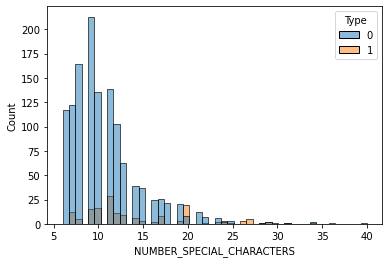

In [6]:
sns.histplot(df_train, x='NUMBER_SPECIAL_CHARACTERS', hue='Type')

<AxesSubplot:xlabel='URL_LENGTH', ylabel='Count'>

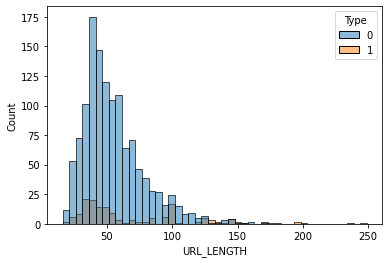

In [8]:
sns.histplot(df_train, x='URL_LENGTH', hue='Type')

<AxesSubplot:xlabel='CONTENT_LENGTH', ylabel='Count'>

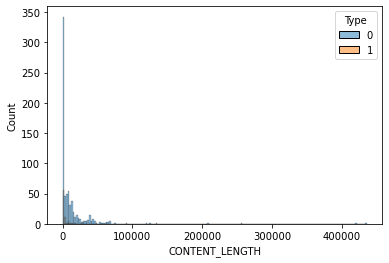

In [9]:
sns.histplot(df_train, x='CONTENT_LENGTH', hue='Type')

<AxesSubplot:xlabel='TCP_CONVERSATION_EXCHANGE', ylabel='Count'>

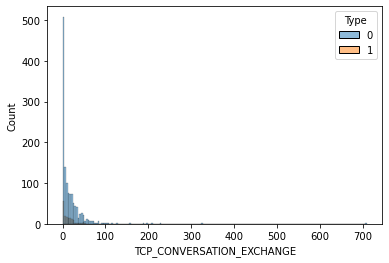

In [10]:
sns.histplot(df_train, x='TCP_CONVERSATION_EXCHANGE', hue='Type')

<AxesSubplot:xlabel='DIST_REMOTE_TCP_PORT', ylabel='Count'>

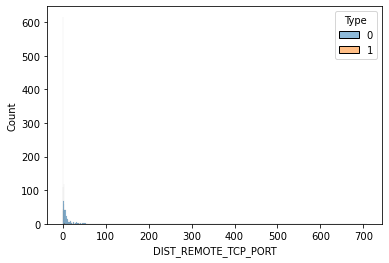

In [11]:
sns.histplot(df_train, x='DIST_REMOTE_TCP_PORT', hue='Type')

In [4]:
df_train.select_dtypes(include='number').columns.tolist()[:-3]

['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'CONTENT_LENGTH',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES']

In [5]:
numeric_columns =['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'CONTENT_LENGTH',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES']

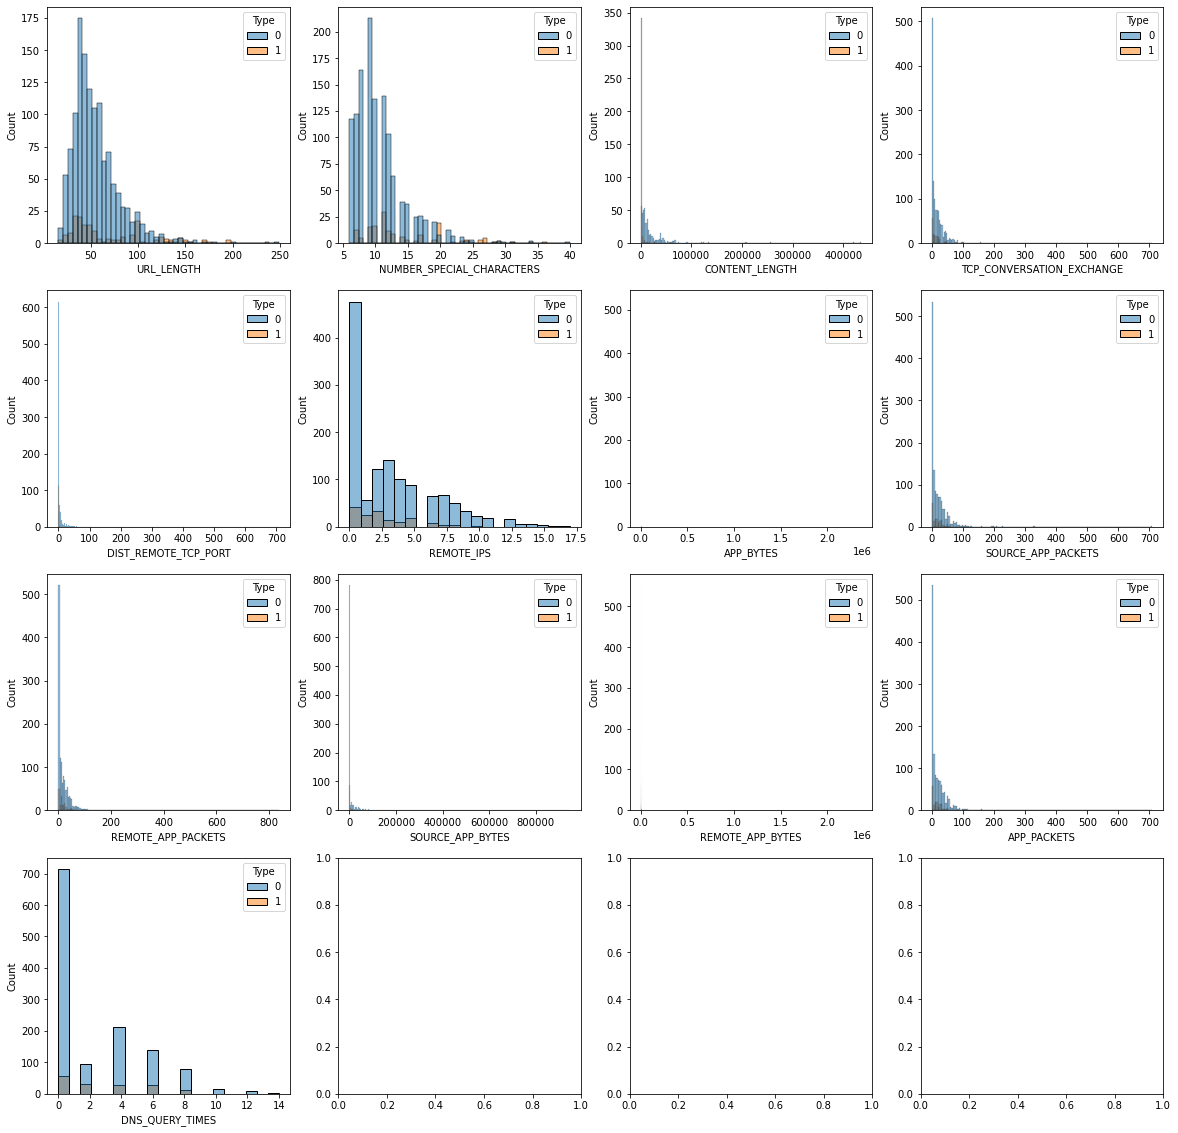

In [25]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
ax = ax.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df_train, x=col, hue='Type', ax=ax[i])


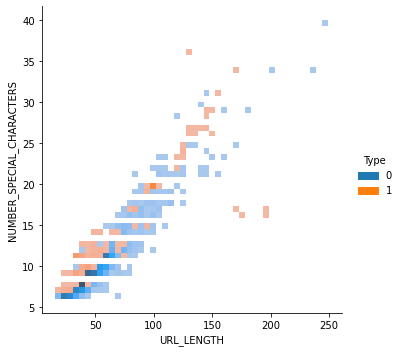

In [6]:
numeric_columns =['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'CONTENT_LENGTH',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES']

sns.displot(df_train, x=df_train[numeric_columns[0]], y=df_train[numeric_columns[1]] , hue='Type')

## Decision Tree

In [9]:


df_train.sort_values(by=['Type']+numeric_columns, ascending=False)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,WHOIS_REGDATE_TS_INT,WHOIS_UPD_TS_INT,WHOIS_REGDATE_TS,WHOIS_UPD_TS
1426,M4_45,194,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,3,186,0,0,0.0,1,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1427,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,3,186,0,0,0.0,1,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1424,M4_39,178,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,3,186,0,0,0.0,1,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1423,M4_61,173,34,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,5,416,90,1,0.0,1,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
1422,M4_43,170,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,2,124,0,0,0.0,1,1221602400,1472767200,1970-01-01 00:00:01.221602400,1970-01-01 00:00:01.472767200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,B0_462,18,6,iso-8859-1,Apache/2,345.0,US,CO,29/07/2002 0:00,1/07/2016 0:00,...,13,8559,1327,14,2.0,0,1027893600,1467324000,1970-01-01 00:00:01.027893600,1970-01-01 00:00:01.467324000
3,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,62,129889,4586,61,4.0,0,831852000,1491861600,1970-01-01 00:00:00.831852000,1970-01-01 00:00:01.491861600
2,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,37,18784,4380,39,8.0,0,876189600,1378939500,1970-01-01 00:00:00.876189600,1970-01-01 00:00:01.378939500
0,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,19,1265,1230,17,0.0,0,-1,-1,1969-12-31 23:59:59.999999999,1969-12-31 23:59:59.999999999


# Feature selection

# Model training

# Model evaluation

# Prediction and Saving results